In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('./GOOGL_weekly_return_volatility.csv')
year1 = df[df.Year == 2019]
year2 = df[df.Year == 2020]

[0.9090909090909091, 0.8636363636363636, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091]


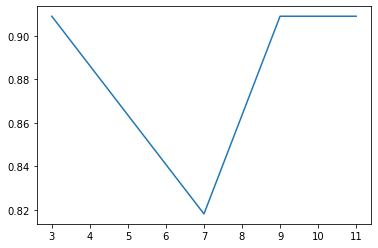

In [3]:
# year1 knn accuracy
kList = [3,5,7,9,11]
accuracy = []
x = year1[['mean_return', 'volatility']]
y = year1.label
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.4, random_state=0)
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xTrain, yTrain)
    yPredict = knn.predict(xTest)
    accuracy.append(accuracy_score(yTest, yPredict))

plt.plot(kList, accuracy)
print(accuracy)

In [10]:
# Optimal k is 3,9,11
kList = [3,9,11]
accuracy = []
x = year1[['mean_return', 'volatility']]
y = year1.label
xTest = year2[['mean_return', 'volatility']]
yTest = year2.label
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x, y)
    yPredict = knn.predict(xTest)
    print('k = {}, accuracy = {}'.format(k, accuracy_score(yTest, yPredict)))


# Confusion Matrix I choose k = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xTrain, yTrain)
labelYear2 = knn.predict(xTest)

temp = confusion_matrix(yTest, labelYear2)
print(temp)

tpr = temp[0][0] / (temp[0][0] + temp[0][1])
tnr = temp[1][1] / (temp[0][1] + temp[1][1])
print('TPR = {}, TNR = {}'.format(tpr, tnr))


k = 3, accuracy = 0.8867924528301887
k = 9, accuracy = 0.9433962264150944
k = 11, accuracy = 0.9811320754716981
[[29  0]
 [ 0 24]]
TPR = 1.0, TNR = 1.0


# Strategy Based on Labels vs BH

In [14]:
dfDetail = pd.read_csv("./GOOGL_weekly_return_volatility_detailed.csv")
dfYear2 = dfDetail[dfDetail.Year == 2020]
year2.label = labelYear2


## Add label to detail
labelMap = {}
for (y, w, l) in zip(year2.Year, year2.Week_Number, year2.label):
    key = (y, w)
    value = l
    labelMap[key] = value

temp = []
for (y, w) in zip(dfYear2.Year, dfYear2.Week_Number):
    key = (y, w)
    temp.append(labelMap[key])

## Extract data
dfYear2['Label'] = temp
dfYear2 = dfYear2[['Year', 'Week_Number', 'Close', 'Label']]

## Cut goo2020
goo2020Week = []
for i in range(53):
    temp = dfYear2[dfYear2.Week_Number == i]
    temp = temp.reset_index(drop=True)
    goo2020Week.append(temp)



C:\Users\Lee\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-14-d3b9f897e9e2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfYear2['Label'] = temp


,Year,Week_Number,Close,Label
252,2020,0,1368.680054,1
253,2020,0,1361.520020,1
254,2020,1,1397.810059,1
255,2020,1,1395.109985,1
256,2020,1,1405.040039,1
...,...,...,...,...
499,2020,51,1728.229980,0
500,2020,51,1734.160034,0
501,2020,52,1773.959961,0
502,2020,52,1757.760010,0


In [6]:
def proficCalculator(data, fund):
    # Week 0 case
    week1Data = data[0]
    week1Label = week1Data.Label[0] # week 0 label

    if week1Label == 1:
        stock = True
        buyPrice = week1Data.Close[0] # week 0 first day price
        sellPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price
    else:
        stock = False
        buyPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price
        sellPrice = week1Data.Close[len(week1Data)-1] # week 0 last day price


    for df in data[1:]:
        nextWeekColor = df.Label[0]
        nextClosePrice = df.Close[len(df)-1]

        # stock + green = no action
        if (stock == True) and (nextWeekColor == 1):
            stock == True # Keep holding the stock
            buyPrice = buyPrice # Buy point stay
            sellPrice = nextClosePrice # Sell point move forward

        # stock + red = sell
        elif (stock == True) and (nextWeekColor == 0):
            r = 1 + (sellPrice - buyPrice) / sellPrice
            fund = fund * r
            buyPrice = nextClosePrice
            sellPrice = nextClosePrice
            stock = False
            
        # money + green = buy stock
        elif (stock == False) and (nextWeekColor == 1):
            buyPrice = buyPrice
            sellPrice = nextClosePrice
            stock = True
        # money + red = no action
        elif (stock == False) and (nextWeekColor == 0):
            buyPrice = nextClosePrice
            sellPrice = nextClosePrice
            stock = False

    # Last withdraw
    r = 1 + (sellPrice - buyPrice) / sellPrice
    fund = fund * r
    return fund


if __name__ == "__main__":
    # Trading base on my label
    total = proficCalculator(goo2020Week, 100)
    print("Using Label: {}".format(total))

    # Buy and hold 
    first = goo2020Week[0]
    first = first.Close[0]

    last = goo2020Week[-1]
    last = last.Close[len(last)-1]

    r = 1 + (last - first) / last
    total = 100 * r
    print("Buy on first day and Sell on last day: {}".format(total))

Using Label: 215.85697376702737
Buy on first day and Sell on last day: 121.17033527942765
